In [1]:
from __future__ import print_function
import IPython
import sys
import numpy as np
import os
import re
import pandas as pd
from tqdm import tqdm
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import librosa as sf
import librosa.display as sfd
%matplotlib inline

/Users/dandamian/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
IPython.display.Audio('./donateacry-ios-upload-bucket/0D1AD73E-4C5E-45F3-85C4-9A3CB71E8856-1430742197-1.0-m-04-hu.caf')

In [3]:
train_dir_ios = './donateacry-ios-upload-bucket/'
train_dir_android = './donateacry-android-upload-bucket/'

In [6]:
ios_paths = [os.path.join(train_dir_ios, x) for x in os.listdir(train_dir_ios)]
audio_set = []
sample_rates = []
reason_set = []
mel_set = []
for p in tqdm(ios_paths):
    audio, sr = sf.load(p, sr=None)
    sample_rates.append(sr)
    audio_set.append(audio)
    mel = sf.feature.melspectrogram(y=audio, sr=sr)
    mel = np.array(mel)
    mel_set.append(mel)
    y=p.split('-')[-1].split('.')[0]
    reason_set.append(y)


100%|██████████| 384/384 [00:07<00:00, 54.26it/s]


In [7]:
android_paths = [os.path.join(train_dir_android, x) for x in os.listdir(train_dir_android)]
for p in tqdm(ios_paths):
    audio, sr = sf.load(p, sr=None)
    sample_rates.append(sr)
    audio_set.append(audio)
    mel = sf.feature.melspectrogram(y=audio, sr=sr)
    mel_set.append(mel)
    y=p.split('-')[-1].split('.')[0]
    reason_set.append(y)

100%|██████████| 384/384 [00:06<00:00, 62.40it/s]


In [8]:
print(len(audio_set))
print(len(sample_rates))
print(len(reason_set))

768
768
768


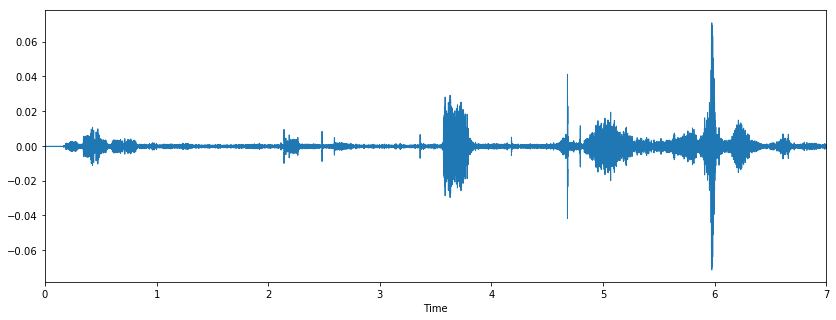

In [9]:
plt.figure(figsize=(14, 5))
sfd.waveplot(audio_set[0], sr=sample_rates[0])

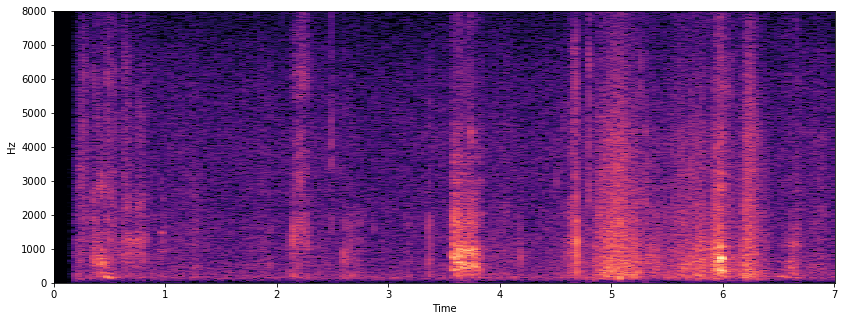

In [10]:
X = sf.stft(audio_set[0])
Xdb = sf.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
sfd.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')

In [11]:
# Find length of shortest sound, used later to normalize sound lengths
max_length = max([len(x) for x in audio_set])
max_length

112000

In [12]:
# pad all samples to the length of the longest sample so they fit into keras
for i, x in enumerate(audio_set):
    audio_set[i] = np.pad(np.array(x), [(0, max_length - len(x))], mode='constant')

In [13]:
# convert list of numpy arrays into single numpy array for consumption
x_train = np.array(audio_set)
x_train.shape

(768, 112000)

In [14]:
s = pd.Series(reason_set)
s_enc = pd.factorize(s)
y_train = s_enc[0]
y_train = np.array(y_train)
y_train = keras.utils.to_categorical(y_train, num_classes=9)
y_train.shape

(768, 9)

In [15]:
s.value_counts()

hu    480
dk    118
ti     64
dc     38
bp     32
bu     16
lo     12
ch      4
sc      4
dtype: int64

In [16]:
x_train[0].shape

(112000,)

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.33, random_state=42)

# Model 2

In [31]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=x_train[0].shape))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(9, activation='softmax'))

In [32]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                7168064   
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 9)                 585       
Total params: 7,172,809
Trainable params: 7,172,809
Non-trainable params: 0
_________________________________________________________________


In [33]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [34]:
model.fit(X_train, Y_train, epochs=30, batch_size=16)

Epoch 1/30
514/514 [==============================] - 4s 8ms/step - loss: 2.2836 - acc: 0.3171
Epoch 2/30
514/514 [==============================] - 3s 7ms/step - loss: 2.2264 - acc: 0.5953
Epoch 3/30
514/514 [==============================] - 3s 7ms/step - loss: 1.8613 - acc: 0.6595
Epoch 4/30
514/514 [==============================] - 4s 7ms/step - loss: 1.8017 - acc: 0.6732
Epoch 5/30
514/514 [==============================] - 3s 7ms/step - loss: 1.6280 - acc: 0.7043
Epoch 6/30
514/514 [==============================] - 5s 9ms/step - loss: 1.4675 - acc: 0.7393
Epoch 7/30
514/514 [==============================] - 4s 7ms/step - loss: 1.5250 - acc: 0.7568
Epoch 8/30
514/514 [==============================] - 4s 7ms/step - loss: 1.3183 - acc: 0.7412
Epoch 9/30
514/514 [==============================] - 4s 7ms/step - loss: 1.2909 - acc: 0.7646
Epoch 10/30
514/514 [==============================] - 4s 7ms/step - loss: 1.2929 - acc: 0.7763
Epoch 11/30
514/514 [============================

In [35]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 1.1435443341262697
Test accuracy: 0.7795275604631019


In [36]:
model.save_weights("model2.h5")

# Model Eval

In [37]:
Y_pred = model.predict_classes(X_test)

In [38]:
print(Y_pred)

[5 0 0 0 4 0 5 0 0 2 1 0 1 4 4 0 2 0 1 0 0 1 0 5 2 1 0 0 0 0 0 0 0 0 0 0 0
 5 2 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1
 0 1 1 1 1 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 2 0 0 0 1 0 1 4 0 0 0 2 0 0 0 0 0
 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 1 0 4 0 1 0 1 0 5 0 0 2 0 0 0 0 0 1
 1 0 1 0 0 0 0 0 2 0 0 5 0 0 0 0 5 0 1 0 0 2 0 0 0 0 2 0 0 0 0 1 0 0 1 1 1
 5 1 1 0 1 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 5 0 1 0 0 5 0 0 0 0 5 0 0 0 0
 0 0 0 0 0 2 2 1 0 0 0 0 1 2 1 0 0 0 0 0 0 0 0 0 0 0 0 0 5 1 0 2]


In [39]:
Y_test_N = [np.where(r==1)[0][0] for r in Y_test]

In [40]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(Y_test_N,Y_pred)

In [41]:
print(conf_mat)

[[144  12   0   0   0   2   0   0   0]
 [ 10  25   0   0   0   0   0   0   0]
 [ 10   1  13   0   0   0   0   0   0]
 [  2   2   1   0   0   0   0   0   0]
 [  5   0   0   0   5   0   0   0   0]
 [  3   0   0   0   0  11   0   0   0]
 [  1   0   0   0   0   0   0   0   0]
 [  5   1   0   0   0   0   0   0   0]
 [  1   0   0   0   0   0   0   0   0]]


In [ ]:
index = ['hu', 'dk', 'ti', 'bu', 'bp', 'dc', 'ch', 'lo', 'sc']

# Other models